# Testing Accuracy Using Ground Truth Boxes

In [1]:
import cv2
import numpy as np
import pandas as  pd
import matplotlib.pyplot as plt
import random
import glob

In [2]:
def get_gt_contours(i,digitStruct):
    gt_contours = []
    boxes = digitStruct.loc[f'{str(i)}.png', 'boxes']
    for box in boxes:
        x = box['left']
        y = box['top']
        w = box['width']
        h = box['height']
        label = int(box['label'])
        gt_contours.append([x, y, x+w, y+h,label])
    return gt_contours

In [10]:
new_templates = []
for i in range(2,92):
    tmp = cv2.imread(f'NEW_NUMBERS/{i}.jpg')
    gray = cv2.cvtColor(tmp, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
    new_templates.append(thresh)
for row in range(1,11):
    for col in range(1,11):
        template = cv2.imread(f"Templates/numbers/PineTools.com_2023-05-08_07h18m28s/PineTools.com_files/row-{row}-column-{col}.png")
        gray = cv2.cvtColor(template,cv2.COLOR_BGR2GRAY)
        thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
        new_templates.append(thresh)
        
for row in [1,2,3,4,6]:
    for col in range(0,10):
        template = cv2.imread(f"Templates/numbers/templates/row-{row}-column-{col}.png")
        gray = cv2.cvtColor(template,cv2.COLOR_BGR2GRAY)
        thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
        new_templates.append(thresh)

240


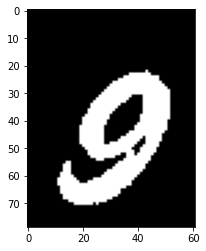

In [19]:
plt.imshow(new_templates[209],cmap = 'gray')
print(len(new_templates))

In [4]:
win_size = (20, 20)   
block_size = (10, 10) 
block_stride = (5, 5) 
cell_size = (5, 5)    
nbins = 9             

hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)

In [20]:
def test_accuracy(dataset,images_number):
    digitStruct = pd.read_json(f'data/{dataset}/digitStruct.json')
    digitStruct.set_index('filename', inplace=True)
    total_accuracy=0
    for i in range(1,images_number+1):
        img_accuracy=0
        img = cv2.imread(f'data/{dataset}/{i}.png')
        img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        gt_contours = []
        gt_contours = get_gt_contours(i,digitStruct)
        gt_contours = [list(map(int,contour)) for contour in gt_contours]
        if len(gt_contours) == 0:
            continue
        for contour in gt_contours:
            score=0
            [x1, y1, x2, y2,label] = contour
            digit = img_gray[y1:y2,x1:x2]
            try:
                digit_resized = cv2.resize(digit, win_size)
            except:

                continue
            digit_hog = hog.compute(digit_resized).reshape(-1)
            scores = []
            for i,template in enumerate(new_templates):
                template_resized = cv2.resize(template, win_size)
                template_hog = hog.compute(template_resized).reshape(-1)
                score = np.dot(digit_hog, template_hog)
                scores.append(score)
            tmp = scores.index(max(scores))
            if tmp%10 == label:
                img_accuracy+=1
        img_accuracy/=len(gt_contours)
        total_accuracy+=img_accuracy
        

    total_accuracy/=images_number
 

    print(f"Total Accuracy: {total_accuracy*100:0.3f}%")

In [22]:
test_accuracy('train',33402)

Total Accuracy: 47.144%


In [23]:
test_accuracy('test',13068)

Total Accuracy: 41.637%
